(Started) implementation of a naive triton kernel for hqq-fwd.

Stopped, because we chose to implement the axis=1 version instead.

In [ ]:
import os
import torch
import numpy as np

from torch import tensor, cat, int32, float16 as fp16, bfloat16 as bf16, isclose
from tabulate import tabulate

os.environ['TRITON_INTERPRET'] = '1'

import triton
import triton.language as tl

from triton_util import *

torch.set_printoptions(linewidth=200, precision=2, sci_mode=False)
np.set_printoptions(linewidth=200, precision=2) # for triton simulator

In [ ]:
dtype = fp16 # can't use bf16 with triton simulator, as numpy doesn't support bf16

In [ ]:
b,m,r,n = 2,5,3,4 # batch size, out, lora rank, in
gz, gz2, pz = 4, 5, 10    # group size, group size for quanting zero & scale, pack size (needs to be 10, as we pack 10 x 3bit -> 32bit)

n_p = cdiv(gz,  pz) # number of packs per group (can't name it np due to numpy)
ng  = cdiv(m*n, gz) # number of groups
ng2 = cdiv(ng , gz2)# number of groups for quanting zero/scale

print(f'{n_p = }, {ng = }, {ng2 = }')

n_p = 1, ng = 5, ng2 = 1


In [ ]:
assert ng%gz2==0, f'num_groups ({ng}) needs to divide group_size_2 ({gz2}) for quanting of zero & scale to work'

In [ ]:
def ones(*shape): return torch.ones(*shape, dtype=dtype, device='cuda')

X, A, B = ones(b,n), ones(r,n), ones(m,r)

mag = ones(m) # magnitude
α = 0.9

scale_q, zero_q = ones(gz2, ng2), ones(gz2, ng2)

s_scale, s_zero, z_scale, z_zero = ones(1, ng2), ones(1, ng2), ones(1, ng2), ones(1, ng2)

packed_value = (1 << 29) + (1 << 26)  # first 2 packs set to 1, other 0: 001 001 00000000000000000000000000

bit_repr = [int(o) for o in format(packed_value & 0xFFFFFFFF, '032b')]
assert sum(bit_repr)==2 # only 2 ones...
assert (bit_repr[2], bit_repr[5])==(1,1) # ... at location 2 and 5 

W_qp = torch.full((n_p,ng), packed_value, dtype=int32)

In [ ]:
W_qp

tensor([[603979776, 603979776, 603979776, 603979776, 603979776]], dtype=torch.int32)

In [ ]:
W_shape = (m, n)
zero_scale_shape = (1, ng)
print(f'{W_shape = }, {zero_scale_shape = }')

W_shape = (5, 4), zero_scale_shape = (1, 5)


In [ ]:
def fwd_op(fwd_k, bs_b, bs_m, bs_r, bs_n):
    # for simplicity, following vars are used from closure & will instead be passed in actual op:
    #   X, A, B, W_qp, scale_q, zero_q,
    #   mag, s_scale, s_zero, z_scale, z_zero
    #   α
    #   W_shape, zero_scale_shape 
    # these vars will be computed from in actual op, but are also used from closure for simplicity
    #   b,m,r,n

    Y = torch.zeros((b,m),dtype=bf16, device='cuda')
    assert_tensors_gpu_ready(Y, X, A, B, mag, scale_q, zero_q, s_scale, s_zero, z_scale, z_zero, W_qp)

    grid = (cdiv(b, bs_b), cdiv(m, bs_m))
    print(f'Launching grid of size {grid}')
    
    fwd_k[grid](
        # input matrices
        X, A, B, W_qp, scale_q, zero_q, 
        # input vectors
        mag, s_scale, s_zero, z_scale, z_zero,
        # input scalars
        α,
        # output matrix
        Y,
        # dimensions
        b,m,r,n,
        # grouping / packing configs
        gz, gz2, pz,
        # shapes to undo grouping
        W_shape, zero_scale_shape,
        # block sizes
        bs_b, bs_m, bs_r, bs_n
        # strides
        # todo
    )
    return Y

In [ ]:
@triton.jit
def dequant_zero_or_scale(vals_ptr, zero_ptr, scale_ptr, gz2, ng2, shape):
    vals_q = load_full_2d(vals_ptr,  sz0=gz2, sz1=ng2, stride0=ng2) # quanted zero/scale values; ~ (gz2, ng2)
    zero   = load_full_1d(zero_ptr,  sz=ng2)                        # zero  of zero/scale;       ~ (ng2)
    scale  = load_full_1d(scale_ptr, sz=ng2)                        # scale of zero/scale;       ~ (ng2)
    vals = (vals_q-zero)*scale
    return tl.reshape(vals, shape)

@triton.jit
def row_idx_after_reshape_ceil(ridx, sz0,sz1,gz):
    '''After reshaping a matrix of shape (sz0,sz1) into (gz,-1), what's the new (ceiled) row idx for a given row idx?'''
    idx = (ridx+1)*sz1-1
    ng = cdiv(sz0*sz1,gz)
    return cdiv(idx+1,ng)-1

@triton.jit
def row_idx_after_reshape_floor(ridx, sz0,sz1,gz):
    '''After reshaping a matrix of shape (sz0,sz1) into (gz,-1), what's the new (floored) row idx for a given row idx?'''
    idx = ridx*sz1
    ng = cdiv(sz0*sz1,gz)
    return idx//ng

@triton.jit
def rows_in_W_pq(bs_m, pid1, m, n, gz, pz)
    # row range of W (ie m axis) we need
    row_lo, row_hi = bs_m*pid1, bs_m*(pid1+1)
    # corresponding row range in W_q
    q_row_lo = row_idx_after_reshape_floor(row_lo, sz0=m,sz1=n,gz=gz)
    q_row_hi = row_idx_after_reshape_ceil( row_hi, sz0=m,sz1=n,gz=gz)    
    # corresponding row range in W_qp
    qp_row_lo = q_row_lo//pz
    qp_row_hi = cdiv(q_row_hi, pz)    

    print_once(f'W-rows [{row_lo},{row_hi}] = W_q-rows [{q_row_lo},{q_row_hi}] = W_qp-rows [{qp_row_lo},{qp_row_hi}]')

    return qp_row_lo, qp_row_hi

@triton.jit
def load_W_qp(ptr, row_start, row_end, row_max, ng):
    '''Load selected rows from W_qp (and all cols)'''
    offs0 = tl.arange(row_start, row_end+1) # selected rows
    offs1 = tl.arange(0, ng)                # all cols    
    w_pq_offs = get_2d_offset(offs0, offs1, stride_0=ng)
    w_pq_mask = get_2d_mask  (offs0, offs1, max0=row_max, max1=ng)
    return tl.load(ptr + w_pq_offs, w_pq_mask) 

@triton.jit
def forward_k(
    # input matrices
    X_ptr, A_ptr, B_ptr, W_qp_ptr, scale_q_ptr, zero_q_ptr,
    # input vectors
    mag_ptr, s_scale_ptr, s_zero_ptr, z_scale_ptr, z_zero_ptr,
    # input scalars
    α,
    # output matrix
    Y_ptr,
    # dimensions
    b: tl.constexpr, m: tl.constexpr, r: tl.constexpr, n: tl.constexpr,
    # grouping / packing configs
    gz: tl.constexpr, gz2: tl.constexpr, pz: tl.constexpr,
    # shapes to undo grouping
    W_shape: tl.constexpr, zero_scale_shape: tl.constexpr, 
    # block sizes
    bs_b: tl.constexpr, bs_m: tl.constexpr, bs_r: tl.constexpr, bs_n: tl.constexpr,
    # strides
    # todo
):
    pid0, pid1 = tl.program_id(0), tl.program_id(1) # blocks correspond to chunking of b and m axes

    n_p: tl.constexpr  = cdiv(gz,  pz)  # number of packs per group (can't name it np due to numpy)
    ng:  tl.constexpr  = cdiv(m*n, gz)  # number of groups
    ng2: tl.constexpr  = cdiv(ng,  gz2) # number of groups for quanting zero/scale
    
    # # dequant zero & scale
    zero  = dequant_zero_or_scale(zero_q_ptr,  z_zero_ptr, z_scale_ptr,  gz2, ng2, shape=zero_scale_shape)
    scale = dequant_zero_or_scale(scale_q_ptr, s_zero_ptr, s_scale_ptr,  gz2, ng2, shape=zero_scale_shape)
    # # unpack w
    qp_row_lo, qp_row_hi = rows_in_W_pq(bs_m, pid1, m, n, gz, pz)        # determine which rows of W_qp are relevant
    w_qp = load_W_qp(W_qp_ptr, qp_row_lo, qp_row_hi, row_max=n_p, ng=ng) # load those rows (and all cols)

    breakpoint_once()

    
    # dequant w
    
    # x@w.t
    # x@a.t@b.t
    # build colnorm
    # times alpha, mag, 1/colnorm
    
    pass

In [ ]:
block_sizes = dict(bs_b=2, bs_m=2, bs_r=2, bs_n=2)
fwd_op(forward_k, **block_sizes)

Launching grid of size (1, 3)
W-rows [[0],[2]] = W_q-rows [[0],[2]] = W_qp-rows [[0],[1]]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_34988/2007732302.py", line 2, in <module>
    fwd_op(forward_k, **block_sizes)
  File "/tmp/ipykernel_34988/2312287393.py", line 16, in fwd_op
    fwd_k[grid](
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/triton/runtime/interpreter.py", line 511, in __call__
    self.fn(**args)
  File "/tmp/ipykernel_34988/3613860667.py", line 75, in forward_k
    w_qp = load_W_qp(W_qp_ptr, qp_row_lo, qp_row_hi, row_max=n_p, ng=ng)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/triton/runtime/interpreter.py", line 544, in __call__
    return self.fn(*args, **kwargs)
  File "/tmp/ipykernel_34988/3613860667.py", line 26, in load_W_qp
    offs0 = tl.arange(row_start, row_end+1) # selected rows
  File "/home/

In [ ]:
raise ValueError()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_34988/1518464500.py", line 1, in <module>
    raise ValueError()
ValueError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2142, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1326, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home/zeus/minico

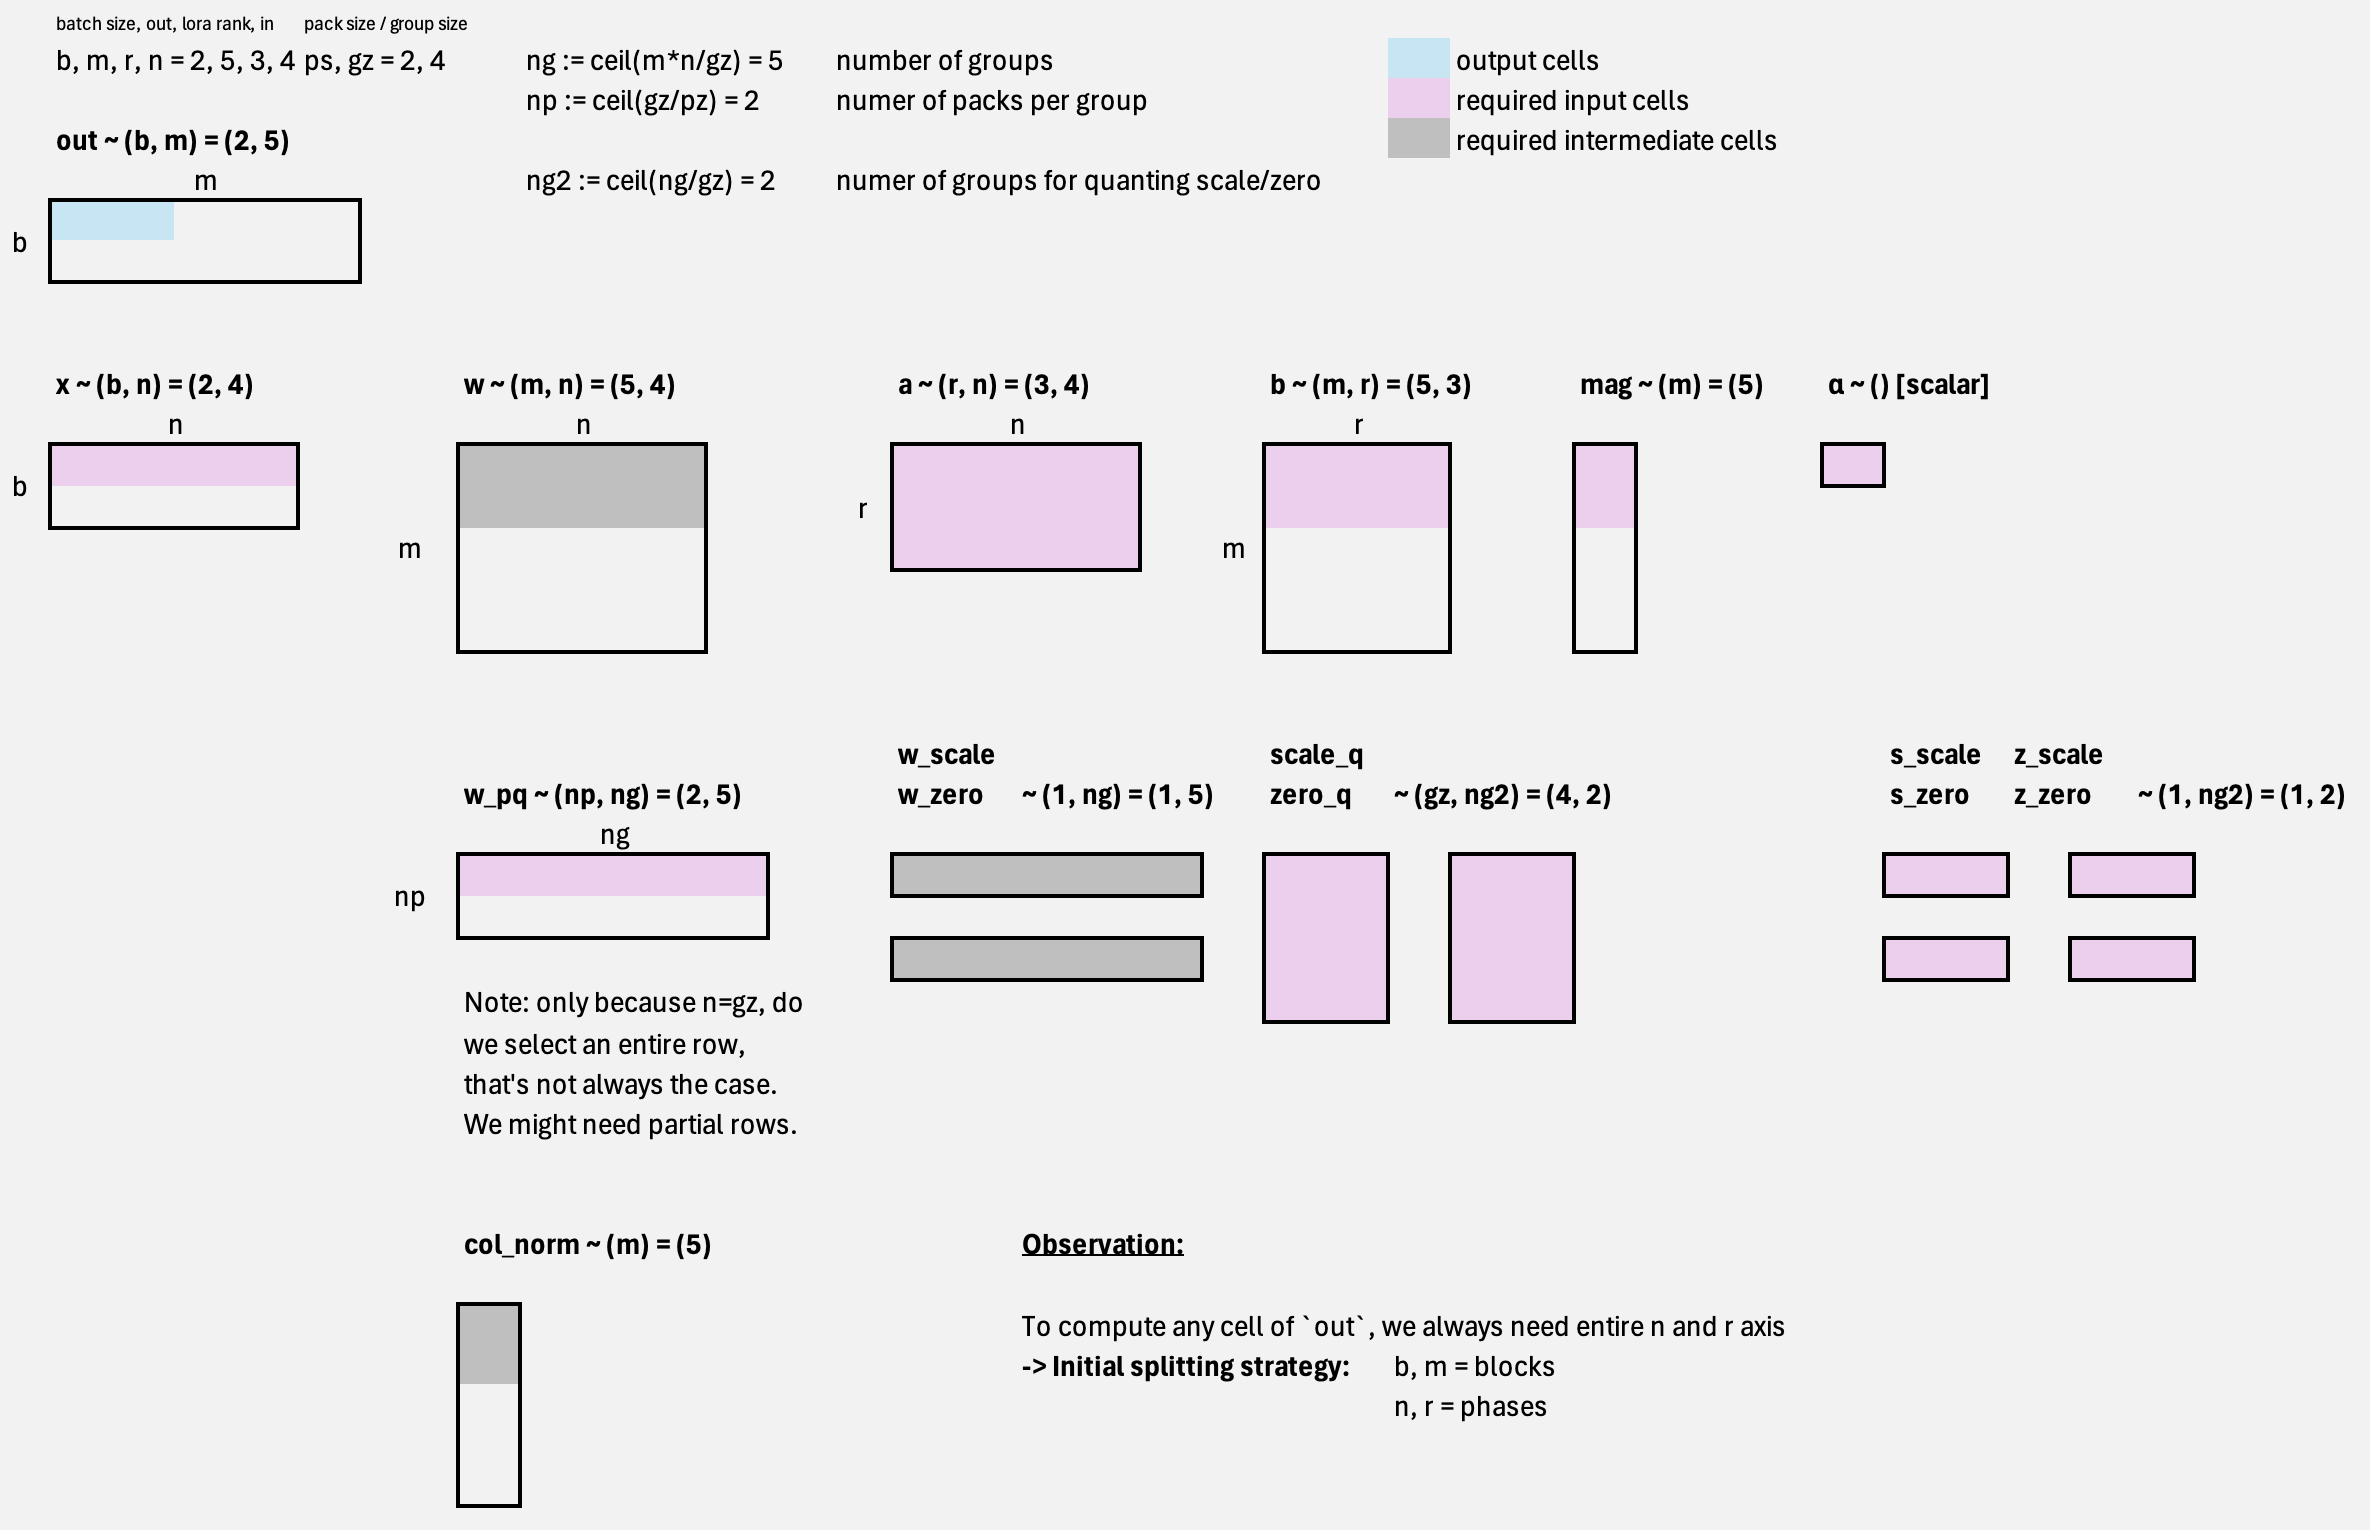

In [ ]:
def row_idx_after_reshape_ceil(ridx, sz0,sz1,gz):
    idx = (ridx+1)*sz1-1
    ng = cdiv(sz0*sz1,gz)
    return idx, ng, cdiv(idx+1,ng)-1

def row_idx_after_reshape_floor(ridx, sz0,sz1,gz):
    idx = ridx*sz1
    ng = cdiv(sz0*sz1,gz)
    return idx, ng, idx//ng

Here's a manual example to see it's correct:

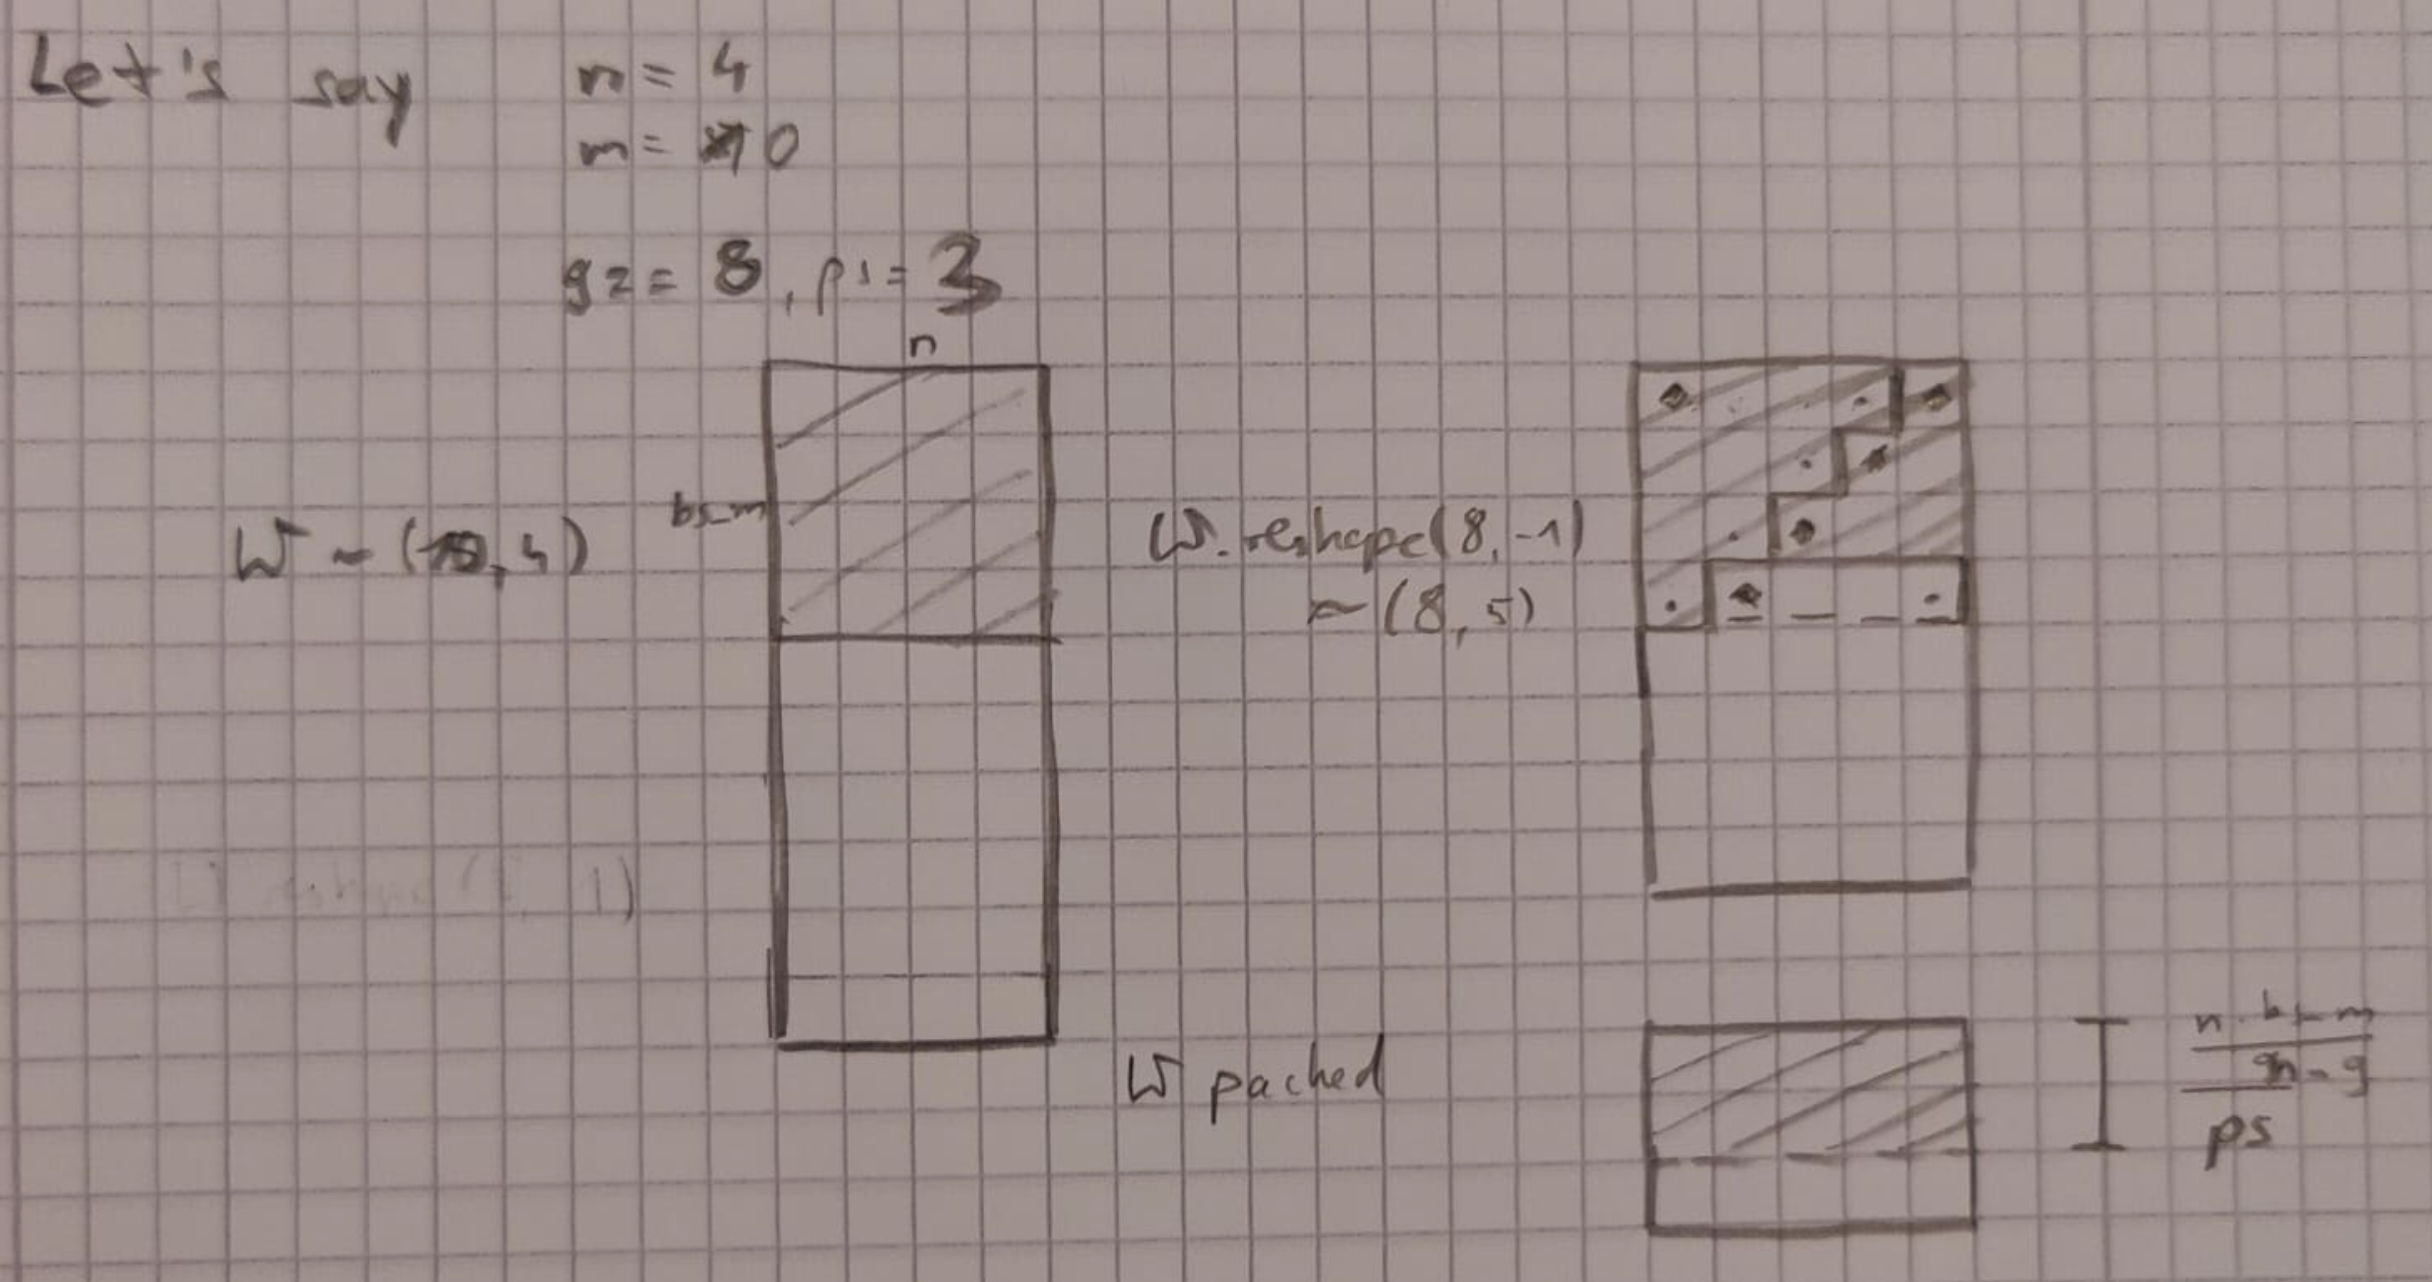

In [ ]:
print(tabulate([(i, *row_idx_after_reshape_ceil(i, 10, 4, 8))for i in range(7)], headers='i idx_before ng idx_after'.split(' ')))

In [ ]:
print(tabulate([(i, *row_idx_after_reshape_floor(i, 10, 4, 8))for i in range(7)], headers='i idx_before ng idx_after'.split(' ')))

In [ ]:
@triton.jit
def do_print(txt):
    p0,p1,p2 = tl.program_id(0), tl.program_id(1), tl.program_id(2)
    print(f'txt {p0} - {p1} - {p2}')

In [ ]:
do_print[(2,)]('yo')